In [ ]:
%tensorflow_version 1.x
!pip install keras-vggface
!pip install scikit-image
!pip install pydot

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip -q '/content/drive/My Drive/dataset2/train.zip' -d dataset
! unzip -q '/content/drive/My Drive/dataset2/test.zip' -d dataset

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize

import pydot

In [ ]:
EPOCHS = 100
BS = 64
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 201

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.0003
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [ ]:
vgg_notop = VGGFace(model='senet50', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(2048, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(512, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)
    
batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False
out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)

cp_filepath='/content/drive/MyDrive/Colab Notebooks'
optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(cp_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# def load_data(path):
#         datagen = ImageDataGenerator(rescale=1./255)
#         return datagen.flow_from_directory(
#                 path,
#                 target_size=(197, 197),
#                 shuffle = True,
#                 class_mode='categorical',
#                 batch_size=BS)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_data(path, split=False):
    if split:
      datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
      return datagen.flow_from_directory(
              path,
              target_size=(Resize_pixelsize, Resize_pixelsize),
              shuffle = True,
              class_mode='categorical',
              batch_size=BS,
              subset='training'), datagen.flow_from_directory(
              path,
              target_size=(Resize_pixelsize, Resize_pixelsize),
              shuffle = True,
              class_mode='categorical',
              batch_size=BS,
              subset='validation')
    else:
      datagen = ImageDataGenerator(rescale=1./255)
      return datagen.flow_from_directory(
              path,
              target_size=(Resize_pixelsize, Resize_pixelsize),
              shuffle = True,
              class_mode='categorical',
              batch_size=BS), None

In [ ]:
train_generator, validation_generator  = load_data('/content/train', True)
test_generator, _  = load_data('/content/test')

Found 17631 images belonging to 7 classes.
Found 4404 images belonging to 7 classes.
Found 5512 images belonging to 7 classes.


In [ ]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=validation_generator, 
    # steps_per_epoch=17631 // 64,
    # validation_steps=4404 // 64,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[rlrop],
    use_multiprocessing=True,
) 

Epoch 1/100
276/276 [==============================] - 127s 459ms/step - loss: 1.5200 - accuracy: 0.4705 - val_loss: 3.3027 - val_accuracy: 0.1399
Epoch 2/100
276/276 [==============================] - 111s 403ms/step - loss: 1.0349 - accuracy: 0.6266 - val_loss: 2.3682 - val_accuracy: 0.1521
Epoch 3/100
276/276 [==============================] - 112s 404ms/step - loss: 0.8560 - accuracy: 0.6973 - val_loss: 1.7419 - val_accuracy: 0.4909
Epoch 4/100
276/276 [==============================] - 112s 404ms/step - loss: 0.7172 - accuracy: 0.7530 - val_loss: 1.1575 - val_accuracy: 0.6069
Epoch 5/100
276/276 [==============================] - 112s 405ms/step - loss: 0.5566 - accuracy: 0.8115 - val_loss: 1.7883 - val_accuracy: 0.6424
Epoch 6/100
276/276 [==============================] - 112s 404ms/step - loss: 0.4392 - accuracy: 0.8504 - val_loss: 0.9481 - val_accuracy: 0.6528
Epoch 7/100
276/276 [==============================] - 112s 404ms/step - loss: 0.3336 - accuracy: 0.8908 - val_loss: 2

In [ ]:
print('\n# Evaluate on validation data')
results_validation = model.evaluate_generator(validation_generator, 4407 // BS)
print('validation loss, validation acc:', results_validation)


# Evaluate on validation data
validation loss, validation acc: [2.5074121952056885, 0.6102941036224365]


In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 5512 // BS)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [3.911336898803711, 0.6026526093482971]


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


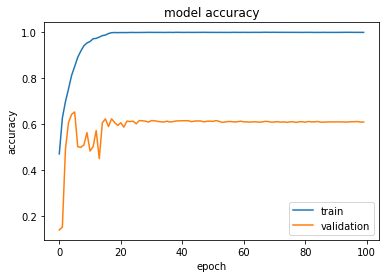

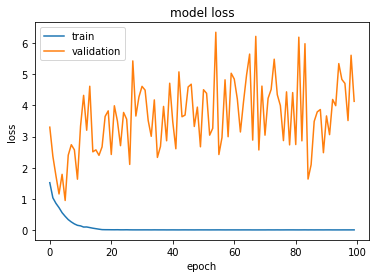

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/Colab Notebooks/' + 'SESNET50' + epoch_str + test_acc + '.h5')